# PPG Peak Detection without Ground‑Truth Labels
**30‑s window, pseudo‑label distillation approach**

This notebook demonstrates how to build a PyTorch pipeline that loads raw PPG recordings from an HDF5 file, generates heuristic peak labels on‑the‑fly, and trains a small 1‑D U‑Net to predict a peak‑probability map.

*Assumptions*
*  HDF5 file created from the .mat dataset (one group per recording). 
*  Each group contains a `ppg` dataset (float32) and attributes `fs`, `subj_id`, `af_status`.

Created: 2025-04-18

https://iopscience.iop.org/article/10.1088/1361-6579/adb89e

In [1]:

# # If you need any extra packages:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# !pip install h5py scipy tqdm
# !pip install torchinfo

# !pip install heartpy

In [2]:
from torchinfo import summary
import h5py, math, random, os, sys, gc
import numpy as np
import scipy.signal as signal
import scipy.ndimage as ndi
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
import heartpy as hp

import torch, os
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
# %matplotlib
# %matplotlib notebook

device = 'cuda' if torch.cuda.is_available() else 'mps'
print('Device:', device)
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"    # avoid crashes on odd ops
torch.mps.empty_cache()                            # call between val runs


Device: mps


In [3]:
t1 = h5py.File("downloaded_files/length_full/train_ds.h5", 'r', swmr=True)
idxs = list(t1.keys())
t1[idxs[0]]['ppg'][:].astype('float32')

array([0.43792766, 0.4281809 , 0.41885287, ..., 0.6707818 , 0.68114376,
       0.6871945 ], shape=(702688,), dtype=float32)

In [4]:

# ----------------------------- configuration -----------------------------
FOLDER_PATH = 'length_full'
H5_PATH = os.path.join('downloaded_files',FOLDER_PATH,'mimic_non_af_data.h5')  # update if your file lives elsewhere
WIN_SEC = 30                      # window length in seconds
FS_ORIGINAL = 125
DEC_FACTOR = 6
FS = round(FS_ORIGINAL/DEC_FACTOR,2)                  # Hz (dataset‑wide constant)
print(FS)
WIN_LEN = int(round(WIN_SEC * FS))            # 3_750 samples
BATCH   = 32
EPOCHS  = 100                       # demo; increase to 30+ for real training

VAR_MULT=500


20.83


In [5]:
from mmpdv2_beat_detector import MMPDV2BeatDetector, mmpdv2_beat_detector

# ----------------------------- helpers -----------------------------------
def bandpass(x, fs=FS, low=0.5, high=8.):
    b, a = signal.butter(2, [low/fs*2, high/fs*2], btype='band')
    return signal.filtfilt(b, a, x)

def pseudo_peak_vector(seg, fs=FS):
    """Return soft (Gaussian) peak map for a 1‑D segment."""
    detector = MMPDV2BeatDetector()        # OO style
    _, locs = detector.detect(seg, fs)

    y = np.zeros_like(seg, dtype='float32')
    y[locs] = 1.
    # y = ndi.gaussian_filter1d(y, sigma=1, mode='constant')
    return y

def find_sliding_window(input_size, target_windows, overlap):
    """
    Finds window_size, hop_size, and number of windows closest to target_windows.

    If `overlap == 0` and `input_size` divides evenly by `target_windows`, returns
    the exact division `(input_size//target_windows, input_size//target_windows, target_windows)`.

    Args:
        input_size (int): Total number of samples in your signal.
        target_windows (int): Desired number of windows.
        overlap (int): Number of samples overlapping between consecutive windows.

    Returns:
        tuple: (window_size, hop_size, num_windows), or None if no valid configuration.
    """
    # Exact division when no overlap
    if overlap == 0 and input_size % target_windows == 0:
        win = input_size // target_windows
        return (win, win, target_windows)

    best_config = None
    best_diff = float('inf')

    # Search for best approximate configuration
    for window_size in range(overlap + 1, input_size + 1):
        hop_size = window_size - overlap
        if hop_size <= 0:
            continue

        num_windows = (input_size - overlap) // hop_size
        if num_windows < 1:
            continue

        diff = abs(num_windows - target_windows)
        divides_evenly = (input_size - overlap) % hop_size == 0
        best_divides = False
        if best_config is not None:
            best_divides = ((input_size - overlap) % best_config[1] == 0)

        # Prefer smaller diff, then even division
        if diff < best_diff or (diff == best_diff and divides_evenly and not best_divides):
            best_diff = diff
            best_config = (window_size, hop_size, num_windows)

    return best_config


def scale_signal(input_vector: torch.Tensor,
                 config: tuple,
                 window_fn=None,
                 method: str = 'norm') -> torch.Tensor:
    """
    Applies standardization or normalization over sliding windows defined by config,
    and reconstructs the full signal via overlap-add.

    Args:
        input_vector (torch.Tensor): 1D tensor of shape (N,).
        config (tuple): (window_size, hop_size, num_windows).
        window_fn (callable, optional): fn(length) -> torch.Tensor of weights.
                                         Defaults to uniform weights.
        method (str): 'standard' for z-score, 'norm' for min-max then zero-mean.

    Returns:
        torch.Tensor: standardized tensor of same shape.
    """
    device = input_vector.device
    dtype = input_vector.dtype
    input_size = input_vector.size(0)
    window_size, hop_size, _ = config

    if window_fn is None:
        window_fn = lambda n: torch.ones(n, device=device, dtype=dtype)

    out = torch.zeros(input_size, device=device, dtype=dtype)
    weights = torch.zeros(input_size, device=device, dtype=dtype)

    for start in range(0, input_size, hop_size):
        end = min(start + window_size, input_size)
        segment = input_vector[start:end]

        if method == 'standard':
            mu = segment.mean()
            sigma = segment.std(unbiased=False)
            if sigma == 0:
                z = torch.zeros_like(segment)
            else:
                z = (segment - mu) / sigma

        elif method == 'norm':
            min_val = segment.min()
            max_val = segment.max()
            denom = max_val - min_val
            if denom == 0:
                z = torch.zeros_like(segment)
            else:
                z = (segment - min_val) / denom
                z = z - z.mean()
        else:
            raise ValueError(f"Unknown method '{method}'")

        w = window_fn(end - start)
        if not torch.is_tensor(w):
            w = torch.tensor(w, device=device, dtype=dtype)

        out[start:end] += z * w
        weights[start:end] += w

        if end == input_size:
            break

    mask = weights > 0
    out[mask] = out[mask] / weights[mask]
    return out


In [6]:
class PPGWindow(Dataset):
    def __init__(self, h5_path, win_len=WIN_LEN, transform=True,var_mult=500,best_config=(100, 75, 8),scale_type="standard"):
        self.h5 = h5py.File(h5_path, 'r', swmr=True)
        # self.ids = list(self.h5.keys())
        self.ids = [gid for gid in self.h5.keys() if 'ppg' in self.h5[gid]]
        self.win = win_len
        self.transform = transform
        self.var_mult = var_mult
        self.best_config = best_config
        self.scale_type = scale_type

        # Precompute valid window-start indices for each record
        self.valid_starts = {}
        for gid in self.ids:
            arr = self.h5[gid]['ppg'][:].astype('float32')
            # pad wrap if too short
            if len(arr) < self.win + 1:
                arr = np.pad(arr, (0, self.win + 1 - len(arr)), mode='wrap')

            ends = len(arr) - self.win + 1
            # vectorized check: slide a window of length win
            # create strided view for mean and std
            # fallback simple loop if memory is a concern
            starts = []
            for s in range(0, ends):
                seg = arr[s:s+self.win]
                if seg.any(): #and seg.std() != 0:
                    starts.append(s)
            self.valid_starts[gid] = np.array(starts, dtype=np.int64)
            
    def __len__(self):
        # virtually infinite; adjust if you want a fixed number
        return len(self.ids) * self.var_mult

    def __getitem__(self, idx):
        # gid = self.ids[idx % len(self.ids)]
        # x   = self.h5[gid]['ppg'][:].astype('float32')

        # # make sure x is long enough
        # if len(x) < self.win + 1:
        #     x = np.pad(x, (0, self.win+1-len(x)), mode='wrap')

        # # keep sampling until we hit at least one non-zero
        # while True:
        #     start = np.random.randint(0, len(x) - self.win)
        #     seg_np = x[start:start+self.win]
        #     if seg_np.any() and seg_np.std() != 0:
        #         break

        # select record and then a valid start index
        gid = self.ids[idx % len(self.ids)]
        starts = self.valid_starts[gid]
        if len(starts) == 0:
            # no valid windows: fallback to uniform sampling
            x = self.h5[gid]['ppg'][:].astype('float32')
            if len(x) < self.win + 1:
                x = np.pad(x, (0, self.win+1-len(x)), mode='wrap')
            s = 0
        else:
            s = int(np.random.choice(starts))
            x = self.h5[gid]['ppg'][:].astype('float32')
            if len(x) < self.win + 1:
                x = np.pad(x, (0, self.win+1-len(x)), mode='wrap')

        seg_np = x[s:s+self.win]

        seg = torch.from_numpy(seg_np)
        seg = scale_signal(seg, self.best_config, method= self.scale_type).float()


        y_np = pseudo_peak_vector(seg.cpu().numpy())    # convert back to numpy
        y = torch.from_numpy(y_np).float()
        return (seg.unsqueeze(0), y, torch.from_numpy(seg_np).unsqueeze(0).float())


In [7]:
TRAIN_PATH = f"downloaded_files/{FOLDER_PATH}/train_ds.h5"


best_config = find_sliding_window(WIN_LEN,target_windows = 5, overlap=25)
scale_type = "norm"
train_ds = PPGWindow(TRAIN_PATH,best_config=best_config,scale_type=scale_type)

from torch.utils.data import random_split

VAL_FRAC = 0.20               # 10 % of the *virtual* samples
n_total  = len(train_ds)
n_val    = int(n_total * VAL_FRAC)
n_train  = n_total - n_val

train_ds, val_ds = random_split(
    train_ds,
    lengths=[n_train, n_val],
    generator=torch.Generator().manual_seed(42)   # reproducible
)

train_loader = DataLoader(train_ds, batch_size=BATCH,
                          shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH,
                          shuffle=True, num_workers=0, pin_memory=False)

print('Dataset ready. Example batch shapes:')
x, y,_ = next(iter(train_loader))
print(x.shape, y.shape)   # (B, 1, 3750) (B, 3750)



Dataset ready. Example batch shapes:
torch.Size([32, 1, 625]) torch.Size([32, 625])


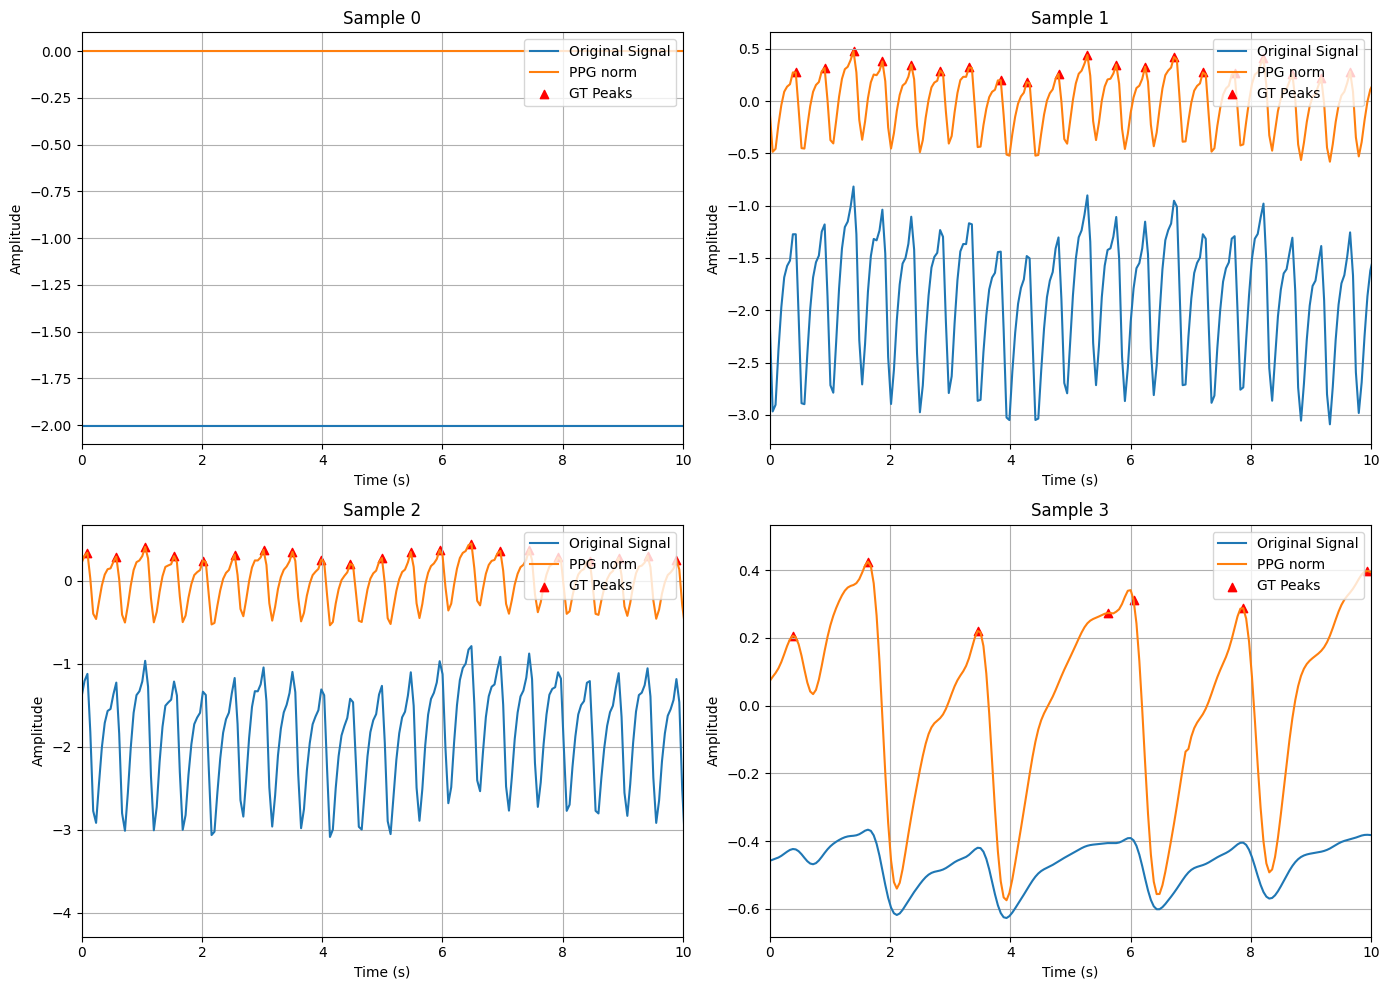

In [8]:
B, _, L = x.shape

# How many to plot
n_plot = min(4, B)
cols   = math.ceil(math.sqrt(n_plot))
rows   = math.ceil(n_plot / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*5), squeeze=False)

for i in range(n_plot):
    x, y,original_signal = next(iter(train_loader))
    ax = axes[i//cols][i%cols]
    seg = scale_signal(x[0,0], best_config,method = scale_type)

    # call your function instead of hp.process
    y = pseudo_peak_vector(seg, fs=FS)
    peaks = np.nonzero(y > 0)[0]
    t = np.arange(len(seg)) / FS
    input_signal = original_signal[0,0]*-1
    seg *= -1


    ax.plot(t,original_signal[0,0]*-1,label='Original Signal')
    ax.plot(t, seg, label=f'PPG {scale_type}')
    ax.scatter(t[peaks], seg[peaks], c='r', marker='^', label='GT Peaks')
    ax.set_title(f'Sample {i}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.legend(loc='upper right')
    ax.grid()
    ax.set_xlim(0,10)

plt.tight_layout()
plt.show()

In [9]:
class EarlyStoppingBasic:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def step(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

In [10]:

# ----------------------------- model -------------------------------------
class ConvBlock(nn.Module):
    def __init__(self, cin, cout, k=9, s=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(cin, cout, k, stride=s, padding=k//2),
            nn.BatchNorm1d(cout),
            nn.ReLU(inplace=True),
            nn.Conv1d(cout, cout, k, stride=1, padding=k//2),
            nn.BatchNorm1d(cout),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class UNet1D(nn.Module):
    def __init__(self, cin=1, base=16, depth=4):
        super().__init__()
        downs, ups, skips = [], [], []
        c = cin
        for d in range(depth):
            downs.append(ConvBlock(c, base*(2**d), k=9))
            c = base*(2**d)
        self.downs = nn.ModuleList(downs)

        # ── ❶ bridge: keep the same #channels, NOT double them  ────────────
        self.bridge = ConvBlock(c, c, k=9)

        # ── decoder   (one up‑conv + cat + convblock at each scale) ───────
        for d in reversed(range(depth-1)):
            ups.append(nn.ConvTranspose1d(c, c//2, 4, stride=2, padding=1))
            ups.append(ConvBlock(c + c//2, c//2, k=9))
            c = c // 2
        self.ups = nn.ModuleList(ups)

        self.head = nn.Conv1d(base, 1, 1)

    def forward(self, x):
        orig_len = x.shape[-1]                # ← ① remember 3 750
        skips = []
        for down in self.downs:
            x = down(x)
            skips.append(x)
            x = nn.functional.avg_pool1d(x, 2)

        x = self.bridge(x)

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)       # up‑conv
            skip = skips[-(i//2 + 1)]
            if x.shape[-1] != skip.shape[-1]:
                diff = skip.shape[-1] - x.shape[-1]
                x = nn.functional.pad(x, (0, diff))
            x = torch.cat([x, skip], dim=1)
            x = self.ups[i+1](x)     # conv block

        if x.shape[-1] != orig_len:
            x = nn.functional.interpolate(x, size=orig_len,mode='linear', align_corners=False)
        return self.head(x).squeeze(1)  # (B, 3750)

In [11]:
LEARNING_RATE = 3e-4;
model = UNet1D().to(device)
print(summary(model, input_size=(1,1, WIN_LEN)))

model = UNet1D().to(device)

optim = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([100.]).to(device))

scaler = torch.amp.GradScaler(enabled=False)       # autocast handles bfloat16

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,'min',factor=0.1,       # drop LR to 10%
    patience=3,       # after 3 epochs of no val_loss improvement
    threshold=1e-3,   # require 0.1% improvement to count
    threshold_mode='rel',
    verbose=True      # print a message when it happens)
)
early_stopper = EarlyStoppingBasic(patience=5, min_delta=1e-3)


Layer (type:depth-idx)                   Output Shape              Param #
UNet1D                                   [1, 625]                  --
├─ModuleList: 1-1                        --                        --
│    └─ConvBlock: 2-1                    [1, 16, 625]              --
│    │    └─Sequential: 3-1              [1, 16, 625]              2,544
│    └─ConvBlock: 2-2                    [1, 32, 312]              --
│    │    └─Sequential: 3-2              [1, 32, 312]              14,016
│    └─ConvBlock: 2-3                    [1, 64, 156]              --
│    │    └─Sequential: 3-3              [1, 64, 156]              55,680
│    └─ConvBlock: 2-4                    [1, 128, 78]              --
│    │    └─Sequential: 3-4              [1, 128, 78]              221,952
├─ConvBlock: 1-2                         [1, 128, 39]              --
│    └─Sequential: 2-5                   [1, 128, 39]              --
│    │    └─Conv1d: 3-5                  [1, 128, 39]              14

/Users/shayanriyaz/miniconda3/envs/AF_DETECTION/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
all_train_loss = []
all_val_loss = []
# ----------------------------- training ----------------------------------
for epoch in range(EPOCHS):
    model.train(); train_loss = 0
    for xb, yb,_ in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}'):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)  
        with torch.autocast("mps", dtype=torch.bfloat16):
            logits = model(xb).float()                 # autocast returns bf16
            loss   = criterion(logits, yb)

        if torch.isnan(loss): raise ValueError('NaN loss')
        
        loss.backward()
        optim.step()
        optim.zero_grad(set_to_none=True)
        train_loss += loss.item()

    mean_train = train_loss / len(train_loader)
    all_train_loss.append(mean_train)
    # ───────────────── validation ─────────────────────────────────────
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb,_ in val_loader:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
            with torch.autocast(device, dtype=torch.bfloat16):
                logits = model(xb).float()
                loss   = criterion(logits, yb)
            val_loss += loss.item()

    mean_val = val_loss / len(val_loader)
    all_val_loss.append(mean_val)

    # ───────────────── bookkeeping ────────────────────────────────────
    scheduler.step(mean_val)         # if ReduceLROnPlateau
    print("lr=", optim.param_groups[0]['lr'])
    stop = early_stopper.step(mean_val)

    print(f"Epoch {epoch+1:02d}  "
          f"train={mean_train:.4f}  val={mean_val:.4f}  "
          f"lr={optim.param_groups[0]['lr']:.2e}")

    if stop:
        print("Early stopping triggered at epoch", epoch+1)
        break

    torch.mps.empty_cache() 



Epoch 1/100: 100%|██████████| 338/338 [01:34<00:00,  3.57it/s]


lr= 0.0003
Epoch 01  train=1.3100  val=1.0995  lr=3.00e-04


Epoch 2/100: 100%|██████████| 338/338 [01:29<00:00,  3.76it/s]


lr= 0.0003
Epoch 02  train=0.9897  val=0.8681  lr=3.00e-04


Epoch 3/100: 100%|██████████| 338/338 [01:29<00:00,  3.78it/s]


lr= 0.0003
Epoch 03  train=0.7995  val=0.7146  lr=3.00e-04


Epoch 4/100: 100%|██████████| 338/338 [01:29<00:00,  3.78it/s]


lr= 0.0003
Epoch 04  train=0.6664  val=0.6059  lr=3.00e-04


Epoch 5/100: 100%|██████████| 338/338 [01:26<00:00,  3.90it/s]


lr= 0.0003
Epoch 05  train=0.5777  val=0.5454  lr=3.00e-04


Epoch 6/100: 100%|██████████| 338/338 [01:26<00:00,  3.89it/s]


lr= 0.0003
Epoch 06  train=0.5273  val=0.5117  lr=3.00e-04


Epoch 7/100: 100%|██████████| 338/338 [01:28<00:00,  3.81it/s]


lr= 0.0003
Epoch 07  train=0.4830  val=0.4610  lr=3.00e-04


Epoch 8/100: 100%|██████████| 338/338 [01:30<00:00,  3.74it/s]


lr= 0.0003
Epoch 08  train=0.4529  val=0.4287  lr=3.00e-04


Epoch 9/100: 100%|██████████| 338/338 [01:29<00:00,  3.78it/s]


lr= 0.0003
Epoch 09  train=0.4306  val=0.4109  lr=3.00e-04


Epoch 10/100: 100%|██████████| 338/338 [01:29<00:00,  3.78it/s]


lr= 0.0003
Epoch 10  train=0.4124  val=0.3932  lr=3.00e-04


Epoch 11/100: 100%|██████████| 338/338 [01:27<00:00,  3.88it/s]


lr= 0.0003
Epoch 11  train=0.4009  val=0.3779  lr=3.00e-04


Epoch 12/100: 100%|██████████| 338/338 [01:26<00:00,  3.90it/s]


lr= 0.0003
Epoch 12  train=0.3831  val=0.3698  lr=3.00e-04


Epoch 13/100: 100%|██████████| 338/338 [01:26<00:00,  3.89it/s]


lr= 0.0003
Epoch 13  train=0.3776  val=0.3797  lr=3.00e-04


Epoch 14/100: 100%|██████████| 338/338 [03:20<00:00,  1.68it/s]


lr= 0.0003
Epoch 14  train=0.3678  val=0.3439  lr=3.00e-04


Epoch 15/100: 100%|██████████| 338/338 [16:34<00:00,  2.94s/it]    


lr= 0.0003
Epoch 15  train=0.3456  val=0.3768  lr=3.00e-04


Epoch 16/100: 100%|██████████| 338/338 [01:32<00:00,  3.64it/s]


lr= 0.0003
Epoch 16  train=0.3410  val=0.3158  lr=3.00e-04


Epoch 17/100: 100%|██████████| 338/338 [01:34<00:00,  3.58it/s]


lr= 0.0003
Epoch 17  train=0.3351  val=0.3401  lr=3.00e-04


Epoch 18/100: 100%|██████████| 338/338 [01:35<00:00,  3.54it/s]


lr= 0.0003
Epoch 18  train=0.3222  val=0.3081  lr=3.00e-04


Epoch 19/100: 100%|██████████| 338/338 [01:35<00:00,  3.54it/s]


lr= 0.0003
Epoch 19  train=0.3185  val=0.3009  lr=3.00e-04


Epoch 20/100: 100%|██████████| 338/338 [01:35<00:00,  3.54it/s]


lr= 0.0003
Epoch 20  train=0.3155  val=0.3030  lr=3.00e-04


Epoch 21/100: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


lr= 0.0003
Epoch 21  train=0.3111  val=0.2985  lr=3.00e-04


Epoch 22/100: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


lr= 0.0003
Epoch 22  train=0.3041  val=0.2802  lr=3.00e-04


Epoch 23/100: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


lr= 0.0003
Epoch 23  train=0.2908  val=0.2846  lr=3.00e-04


Epoch 24/100: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


lr= 0.0003
Epoch 24  train=0.2967  val=0.2813  lr=3.00e-04


Epoch 25/100: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


lr= 0.0003
Epoch 25  train=0.2921  val=0.2843  lr=3.00e-04


Epoch 26/100: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


lr= 0.0003
Epoch 26  train=0.2815  val=0.2653  lr=3.00e-04


Epoch 27/100: 100%|██████████| 338/338 [01:35<00:00,  3.56it/s]


lr= 0.0003
Epoch 27  train=0.2842  val=2348.5439  lr=3.00e-04


Epoch 28/100: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


lr= 0.0003
Epoch 28  train=0.2797  val=0.2774  lr=3.00e-04


Epoch 29/100: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


lr= 0.0003
Epoch 29  train=0.2757  val=58873897056.6332  lr=3.00e-04


Epoch 30/100: 100%|██████████| 338/338 [01:35<00:00,  3.54it/s]


lr= 2.9999999999999997e-05
Epoch 30  train=0.2673  val=2833.5331  lr=3.00e-05


Epoch 31/100: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


lr= 2.9999999999999997e-05
Epoch 31  train=0.2499  val=0.2412  lr=3.00e-05


Epoch 32/100: 100%|██████████| 338/338 [01:35<00:00,  3.55it/s]


lr= 2.9999999999999997e-05
Epoch 32  train=0.2468  val=0.2373  lr=3.00e-05


Epoch 33/100: 100%|██████████| 338/338 [01:35<00:00,  3.54it/s]


lr= 2.9999999999999997e-05
Epoch 33  train=0.2389  val=1339379333818.9575  lr=3.00e-05


Epoch 34/100: 100%|██████████| 338/338 [01:35<00:00,  3.53it/s]


lr= 2.9999999999999997e-05
Epoch 34  train=0.2378  val=0.2322  lr=3.00e-05


Epoch 35/100: 100%|██████████| 338/338 [01:35<00:00,  3.54it/s]


lr= 2.9999999999999997e-05
Epoch 35  train=0.2342  val=0.2296  lr=3.00e-05


Epoch 36/100: 100%|██████████| 338/338 [01:37<00:00,  3.48it/s]


lr= 2.9999999999999997e-05
Epoch 36  train=0.2319  val=0.2250  lr=3.00e-05


Epoch 37/100: 100%|██████████| 338/338 [01:35<00:00,  3.52it/s]


lr= 2.9999999999999997e-05
Epoch 37  train=0.2304  val=0.2312  lr=3.00e-05


Epoch 38/100: 100%|██████████| 338/338 [01:36<00:00,  3.52it/s]


lr= 2.9999999999999997e-05
Epoch 38  train=0.2300  val=0.2211  lr=3.00e-05


Epoch 39/100: 100%|██████████| 338/338 [01:36<00:00,  3.51it/s]


lr= 2.9999999999999997e-05
Epoch 39  train=0.2330  val=0.2184  lr=3.00e-05


Epoch 40/100: 100%|██████████| 338/338 [01:36<00:00,  3.50it/s]


lr= 2.9999999999999997e-05
Epoch 40  train=0.2319  val=0.2162  lr=3.00e-05


Epoch 41/100: 100%|██████████| 338/338 [01:36<00:00,  3.49it/s]


lr= 2.9999999999999997e-05
Epoch 41  train=0.2303  val=0.2184  lr=3.00e-05


Epoch 42/100: 100%|██████████| 338/338 [01:37<00:00,  3.47it/s]


lr= 2.9999999999999997e-05
Epoch 42  train=0.2263  val=2197999632439869884585889234944.0000  lr=3.00e-05


Epoch 43/100: 100%|██████████| 338/338 [01:37<00:00,  3.48it/s]


lr= 2.9999999999999997e-05
Epoch 43  train=0.2265  val=0.2140  lr=3.00e-05


Epoch 44/100: 100%|██████████| 338/338 [01:37<00:00,  3.47it/s]


lr= 2.9999999999999997e-05
Epoch 44  train=0.2241  val=0.2091  lr=3.00e-05


Epoch 45/100: 100%|██████████| 338/338 [01:36<00:00,  3.48it/s]


lr= 2.9999999999999997e-05
Epoch 45  train=0.2243  val=0.2153  lr=3.00e-05


Epoch 46/100: 100%|██████████| 338/338 [01:37<00:00,  3.48it/s]


lr= 2.9999999999999997e-05
Epoch 46  train=0.2217  val=0.2152  lr=3.00e-05


Epoch 47/100: 100%|██████████| 338/338 [01:37<00:00,  3.48it/s]


lr= 2.9999999999999997e-05
Epoch 47  train=0.2241  val=2097084177413493.7500  lr=3.00e-05


Epoch 48/100: 100%|██████████| 338/338 [01:37<00:00,  3.45it/s]


lr= 3e-06
Epoch 48  train=0.2204  val=0.2141  lr=3.00e-06


Epoch 49/100: 100%|██████████| 338/338 [01:36<00:00,  3.49it/s]


lr= 3e-06
Epoch 49  train=0.2182  val=0.2123  lr=3.00e-06
Early stopping triggered at epoch 49


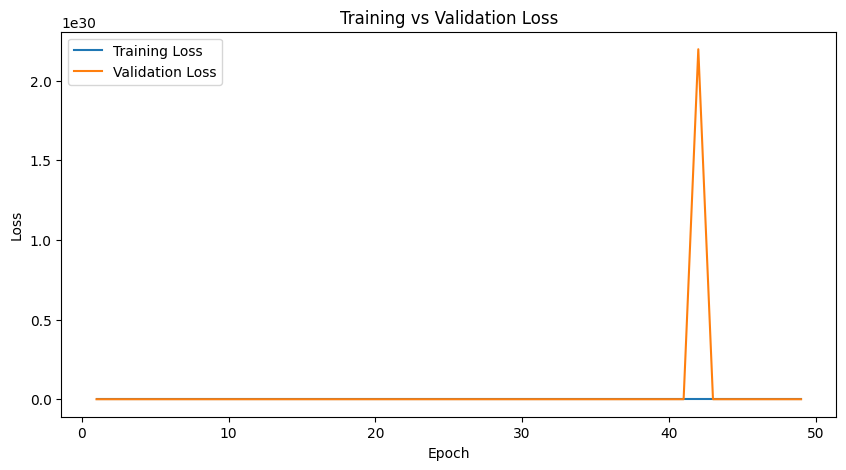

In [13]:
epochs = range(1, len(all_train_loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, all_train_loss, label='Training Loss')
plt.plot(epochs, all_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [19]:
CKPT_FILE = os.path.join('trained_models',f'ppg_peak_unet_{epoch}.pth')
# save weights
torch.save(model.state_dict(), CKPT_FILE)
print('Checkpoint saved.')


Checkpoint saved.


In [ ]:
FOLDER_PATH = 'length_full'
TEST_PATH = os.path.join('downloaded_files',FOLDER_PATH,'test_ds.h5')  # update if your file lives elsewhere
CKPT     = CKPT_FILE



test_ds = PPGWindow(TEST_PATH,best_config=best_config,scale_type=scale_type)

test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=True, num_workers=0, pin_memory=False)

# ------------ load the trained model -------------------------------------
model  = UNet1D().to(device)
model.load_state_dict(torch.load(CKPT, map_location=device))
model.eval()



UNet1D(
  (downs): ModuleList(
    (0): ConvBlock(
      (net): Sequential(
        (0): Conv1d(1, 16, kernel_size=(9,), stride=(1,), padding=(4,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(16, 16, kernel_size=(9,), stride=(1,), padding=(4,))
        (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): ConvBlock(
      (net): Sequential(
        (0): Conv1d(16, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,))
        (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): ConvBlock(
      (net): Sequential(
        (0): Co

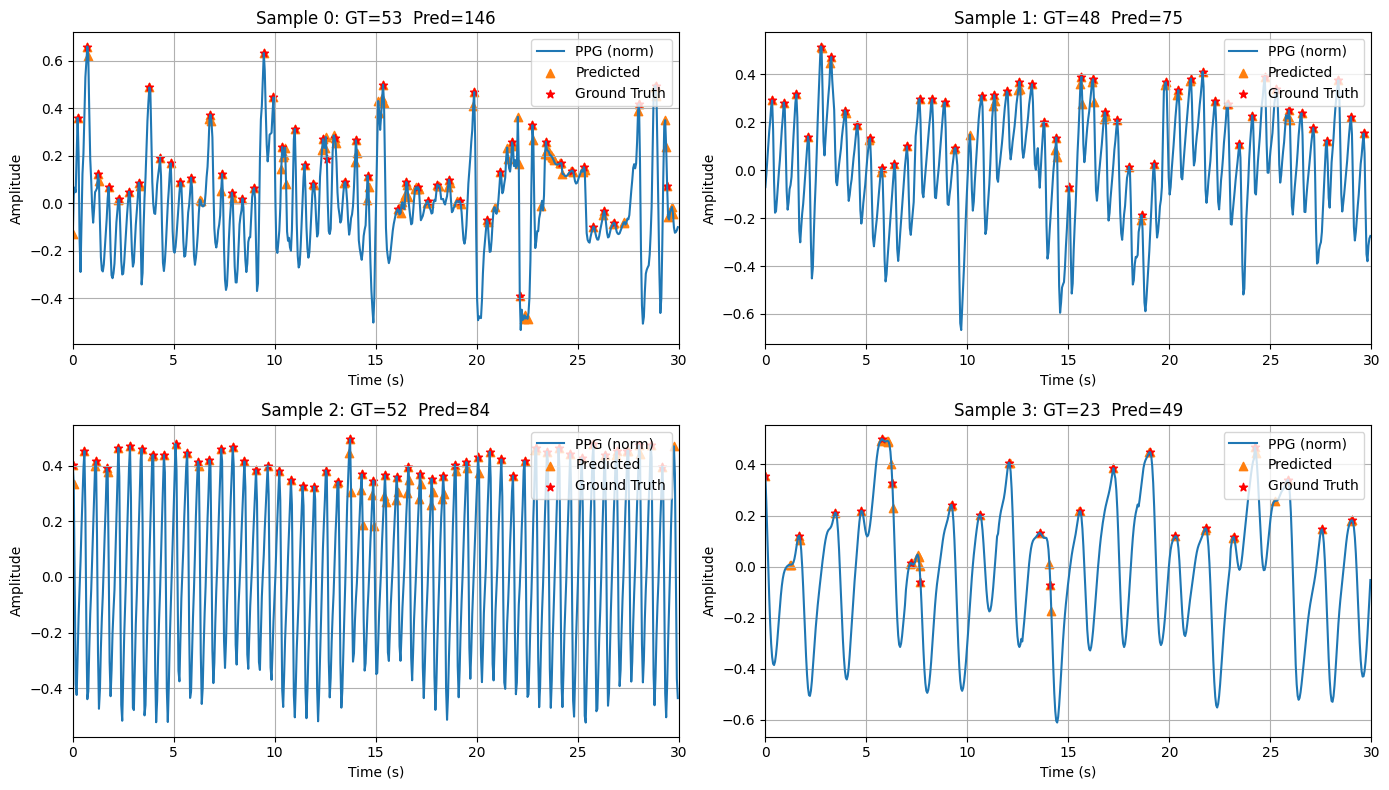

In [17]:
THRESH   = 0.5         # probability cut‑off for “peak”
xb, yb, orig = next(iter(test_loader))     # xb: (B,1,L), yb: (B,L), orig:(B,1,L)
xb, yb, orig = xb.to(device), yb.to(device), orig  # orig can stay on CPU

yb_cpu = yb.cpu().numpy()          # shape (B, L)

B, _, L = x.shape
t = np.arange(L) / FS  # common time axis, shape (L,)
# print(t)
# How many to plot

n_plot = min(4, B)
cols   = math.ceil(math.sqrt(n_plot))
rows   = math.ceil(n_plot / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*7, rows*4), squeeze=False)



for i in range(n_plot):
    ax = axes[i//cols][i%cols]
    # 1) model forward only this window
    
    # 1) raw 625‐point window
    original_window = orig[i,0].numpy()   # shape (L,)
    # if you had inverted sign elsewhere:
    original_window = -original_window

    # 2) normalized window
    window_norm = xb[i,0].cpu().numpy()   # shape (L,)
    # if you invert:
    window_norm = -window_norm

    # 3) model prediction for this window
    inp  = xb[i:i+1].to(device)            # shape (1,1,L)
    with torch.no_grad():
        prob = torch.sigmoid(model(inp))[0]  # shape (L,)
    prob_np    = prob.cpu().numpy()
    peaks_pred = np.where(prob_np > THRESH)[0]

    # 4) ground‑truth peaks from yb
    gt_peaks = np.where(yb_cpu[i] > 0)[0]

    # print(original_window)
    # 5) now plot
    # ax.plot(t, original_window, label='PPG (raw)', alpha=0.7)
    ax.plot(t, window_norm,    label='PPG (norm)', linestyle='-')
    ax.scatter(t[peaks_pred], window_norm[peaks_pred],
               c='C1', marker='^', label='Predicted')
    ax.scatter(t[gt_peaks], window_norm[gt_peaks],
               c='r', marker='*', label='Ground Truth')

    ax.set_title(f"Sample {i}: GT={len(gt_peaks)}  Pred={len(peaks_pred)}")
    ax.set_xlim(0, WIN_SEC)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.legend(loc='upper right')
    ax.grid()

plt.tight_layout()
plt.show()